Some libraries we'll be using:

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import re
import sympy
from numpy.linalg import inv

## Importing data

Locations of the data

In [2]:
UD15_path = '../data/15'
UD30_path = '../data/30'
UD45_path = '../data/45'


DATADIRS = [UD15_path, UD30_path, UD45_path]

col_names = ['Sample elongation (mm)', 'Load (kN)', 'Time (s)', 'Longitudinal strain (_)',
            'Transverse strain (_)', 'Strain +45 (_)', 'Strain -45 (_)', 'Poisson ratio (%)',
            'Real stress (GPa)', 'Real area (mm^2)', 'Strain gauge 0 (_)', 'Strain gauge +45 (_)', 'Strain gauge -45 (_)']

In [3]:
def import_data(datadirs, col_names):
    """
    Imports data from experiments

    Parameters:
    ---------------------------------
    datafiles: list
        List of data locations
    col_names: list
        List of columns in the datafiles

    Returns:
    ----------------------------------
    data: pandas dataframe
        Dataframe containing parsed data
    """
    data_experiments = []
    for datadir in datadirs:
        data = []
        # import data in each module
        for root, subdirs, filenames in os.walk(datadir):
            for filename in filenames:
                if re.match('.*DAQ.*(csv|txt)\Z', filename):
                         file_path = os.path.join(root, filename)
                         data.append(pd.read_csv(file_path, header=None, sep=None, engine='python',
                                    names=col_names, na_values=['no info', '.', 'NaN'], skiprows=8))
                        
        # concatenate the data into one result
        concat_keys = ['Sample ' + str(i) for i in range(len(data))]
        data_experiments.append(pd.concat(data, keys = concat_keys, names=['Sample'])) 

    return data_experiments

In [4]:
data_experiments = import_data(DATADIRS, col_names)

In [5]:
data_experiments[2].head()

Sample elongation (mm)  Load (kN)  Time (s)  \
Sample                                                    
Sample 0 0               -0.000186  -0.085993      0.12   
         1                0.001211  -0.082024      0.22   
         2                0.003307  -0.078360      0.32   
         3                0.005963  -0.073064      0.42   
         4                0.009456  -0.062659      0.52   

            Longitudinal strain (_)  Transverse strain (_)  Strain +45 (_)  \
Sample                                                                       
Sample 0 0                 0.000005           4.221330e-07        0.000015   
         1                -0.000012          -9.496110e-06        0.000002   
         2                -0.000015          -6.524600e-06       -0.000003   
         3                -0.000010           6.297150e-07       -0.000010   
         4                 0.000005           1.312520e-06       -0.000005   

            Strain -45 (_)  Poisson ratio (%)  Real stress (GPa)  \
Sample                                                             
Sample 0 0       -0.000001           9.006368          -0.001911   
         1       -0.000005          76.212150          -0.001823   
         2       -0.000004          44.770303          -0.001741   
         3       -0.000010          -6.604303          -0.001624   
         4        0.000006          28.059268          -0.001392   

            Real area (mm^2)  Strain gauge 0 (_)  Strain gauge +45 (_)  \
Sample                                                                   
Sample 0 0         44.999982           -0.000143             -0.000157   
         1         45.000426           -0.000143             -0.000158   
         2         45.000295           -0.000144             -0.000158   
         3         44.999972           -0.000142             -0.000157   
         4         44.999942           -0.000143             -0.000157   

            Strain gauge -45 (_)  
Sample                            
Sample 0 0              0.000175  
         1              0.000174  
         2              0.000174  
         3              0.000175  
         4              0.000175

OK, let's concatenate that too:

In [6]:
concat_keys = ['UD15', 'UD30', 'UD45']
data = pd.concat(data_experiments, keys=concat_keys, names=['Experiment'])


And delete unnecessary columns

In [7]:
del data['Poisson ratio (%)']
del data['Real stress (GPa)']
del data['Real area (mm^2)']

Let's test that too

In [8]:
raw_data =  data.loc['UD15', 'Sample 0'].head()
del raw_data['Time (s)']

In [9]:
print(raw_data.to_latex(float_format='%.2g', escape = False))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  Sample elongation (mm) &  Load (kN) &  Longitudinal strain (_) &  Transverse strain (_) &  Strain +45 (_) &  Strain -45 (_) &  Strain gauge 0 (_) &  Strain gauge +45 (_) &  Strain gauge -45 (_) \\
\midrule
0 &                  0.0013 &    -0.0032 &                    3e-06 &                  3e-06 &         2.6e-05 &        -5.6e-06 &             0.00045 &              -0.00041 &                 0.055 \\
1 &                  0.0025 &      0.002 &                  9.9e-06 &                9.1e-06 &           3e-05 &        -1.6e-05 &             0.00045 &              -0.00041 &                 0.055 \\
2 &                  0.0041 &      0.011 &                  8.4e-06 &                1.6e-05 &           4e-05 &         1.2e-05 &             0.00045 &              -0.00041 &                 0.055 \\
3 &                  0.0064 &       0.03 &                  1.2e-05 &                3.1e-05 &         5.4e-05 &         2.7e-06 &             0.

And plot a few cases

In [10]:
quickplot_load = lambda data, separator: sns.relplot(x='Sample elongation (mm)', y='Load (kN)', 
                                                data=data, kind='line', hue=separator)
def plot_sample_data(_data, _x, _y):
    data_reset = _data.reset_index(level='Sample')
    return sns.relplot(x=_x, y=_y, data=data_reset, kind='line', hue='Sample')

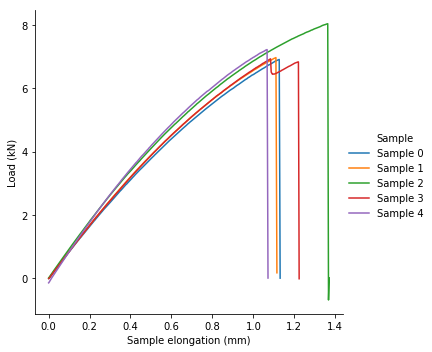

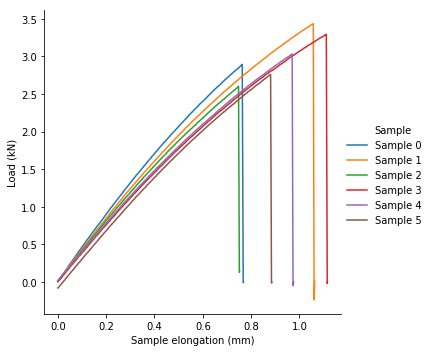

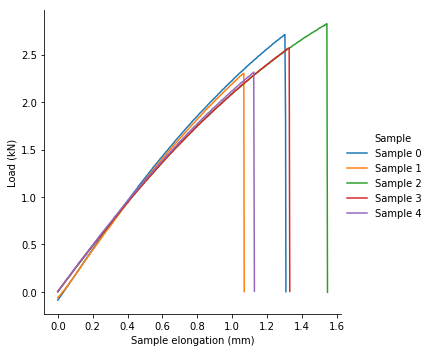

In [11]:
data_reset = data.reset_index(level='Sample')
fig = quickplot_load(data_reset.loc['UD15'], 'Sample')
fig.savefig('../figs/ud15_raw.pdf', format = 'pdf')
fig = quickplot_load(data_reset.loc['UD30'], 'Sample')
fig.savefig('../figs/ud30_raw.pdf', format = 'pdf')
fig = quickplot_load(data_reset.loc['UD45'], 'Sample')
fig.savefig('../figs/ud45_raw.pdf', format = 'pdf')

That works, adding the rest of the geometry

In [12]:
def add_geometry(data, TESTS, WIDTHS, THICKNESSES, FVFS):
    data = data.assign(Width=25e-3, Thickness=2e-3, FVF=0.602)
    data = data.rename(columns = {'Width':'Width (m)', 'Thickness': 'Thickness (m)', 'FVF': 'FVF (_)'})
    for _test, _width, _thickness, _fvf in zip(TESTS, WIDTHS, THICKNESSES, FVFS):
        for i in range(len(_width)):
            sample_name = 'Sample ' + str(i)
            data.loc[(_test, sample_name), 'Width (m)'] = _width[i]
            data.loc[(_test, sample_name), 'Thickness (m)'] = _thickness[i]
            data.loc[(_test, sample_name), 'FVF (_)'] = _fvf
    return data
    
TESTS = ['UD15', 'UD30', 'UD45']
UD15_width = np.array([25.11, 25.09, 25.12, 25.11, 25.13]) * 1e-3
UD30_width = np.array([25.05, 25.05, 25.12, 25.00, 25.06]) * 1e-3
UD45_width = np.array([25.05, 25.04, 25.03, 25.03, 25.03]) * 1e-3

UD15_thickness = np.array([1.75, 1.75, 1.70, 1.68, 1.71]) * 1e-3
UD30_thickness = np.array([1.77, 1.74, 1.75, 1.73, 1.73]) * 1e-3
UD45_thickness = np.array([1.67, 1.67, 1.67, 1.66, 1.70]) * 1e-3

UD15_FVF = 0.602
UD30_FVF = 0.602
UD45_FVF = 0.602


WIDTHS = [UD15_width, UD30_width, UD45_width]
THICKNESSES = [UD15_thickness, UD30_thickness, UD45_thickness]
FVFS = [UD15_FVF, UD30_FVF, UD45_FVF]
data = add_geometry(data, TESTS, WIDTHS, THICKNESSES, FVFS)


# Stress calculations
The standard asks for engineering stress, so we need the sample areas.

In [13]:
areas = data['Width (m)'] * data['Thickness (m)']

In [14]:
stresses = data['Load (kN)'] * 1000 / areas

In [15]:
strain_shear = data['Strain +45 (_)'] - data['Strain -45 (_)']

In [16]:
data = data.assign(Area = areas, Stress = stresses, ShearStrain = strain_shear)
data = data.rename(columns = {'Area':'Area (m^2)', 'Stress': 'Stress (Pa)', 'ShearStrain': 'Shear strain (_)'})

/home/m/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


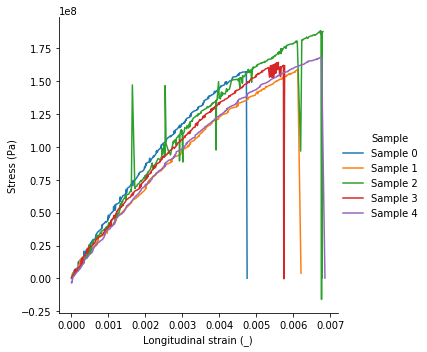

In [17]:
fig = plot_sample_data(data.loc['UD15'][data.loc['UD15', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Stress (Pa)')
fig.savefig('../figs/ud15_ss.pdf', format = 'pdf')

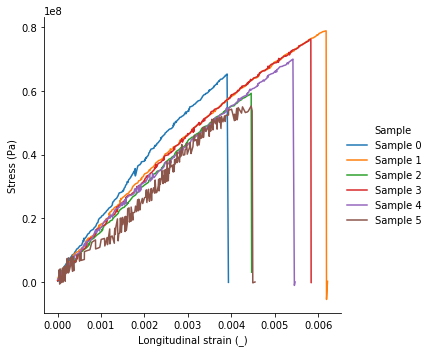

In [18]:
fig = plot_sample_data(data.loc['UD30'][data.loc['UD30', 'Longitudinal strain (_)'] > 0], \
                    'Longitudinal strain (_)', 'Stress (Pa)')
fig.savefig('../figs/ud30_ss.pdf', format = 'pdf')

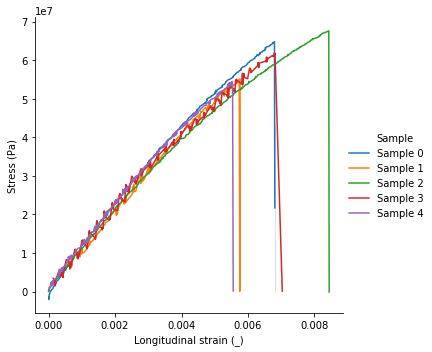

In [19]:
fig = plot_sample_data(data.loc['UD45'][data.loc['UD45', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Stress (Pa)')
fig.savefig('../figs/ud45_ss.pdf', format = 'pdf')

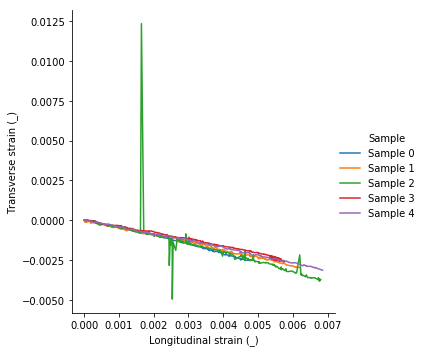

In [20]:
fig = plot_sample_data(data.loc['UD15'][data.loc['UD15', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Transverse strain (_)')
fig.savefig('../figs/ud15_poisson.pdf', format = 'pdf')

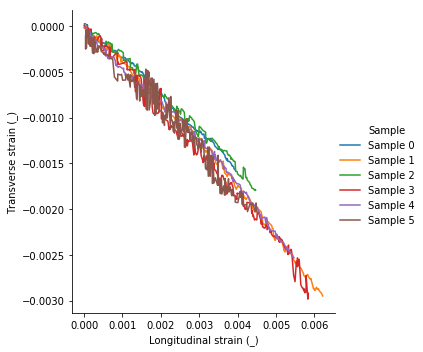

In [21]:
fig = plot_sample_data(data.loc['UD30'][data.loc['UD30', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Transverse strain (_)')
fig.savefig('../figs/ud30_poisson.pdf', format = 'pdf')

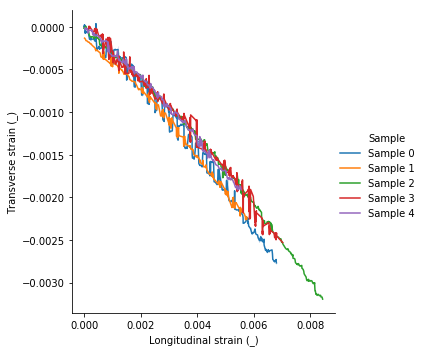

In [22]:
fig = plot_sample_data(data.loc['UD45'][data.loc['UD45', 'Longitudinal strain (_)'] > 0], \
                 'Longitudinal strain (_)', 'Transverse strain (_)')
fig.savefig('../figs/ud45_poisson.pdf', format = 'pdf')

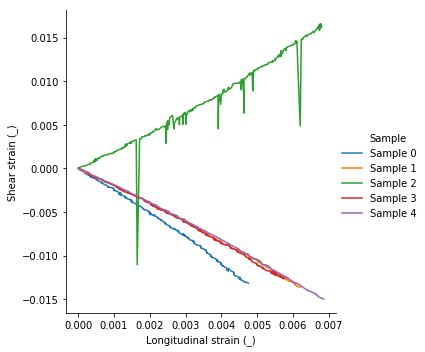

In [23]:
fig = plot_sample_data(data.loc['UD15'][data.loc['UD15', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Shear strain (_)')
fig.savefig('../figs/ud15_coupling.pdf', format = 'pdf')

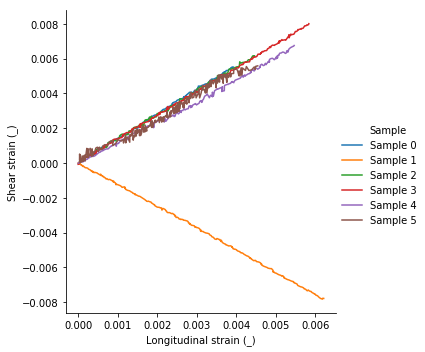

In [24]:
fig = plot_sample_data(data.loc['UD30'][data.loc['UD30', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Shear strain (_)')
fig.savefig('../figs/ud30_coupling.pdf', format = 'pdf')

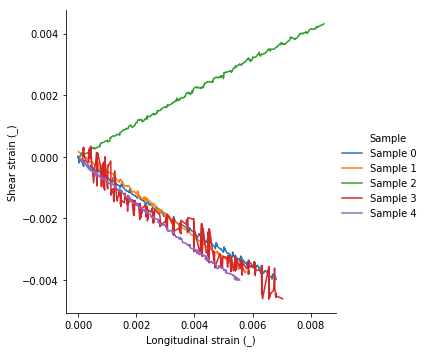

In [25]:
fig = plot_sample_data(data.loc['UD45'][data.loc['UD45', 'Longitudinal strain (_)'] > 0], \
                       'Longitudinal strain (_)', 'Shear strain (_)')
fig.savefig('../figs/ud45_coupling.pdf', format = 'pdf')

# Analysis

In [26]:
def calc_moduli(data, strain_col, strain_low, strain_high, nosamples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []

    for i in range(nosamples):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_col] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_col] - strain_high).abs().idxmin()
        e_h = sample_data['Stress (Pa)'].iloc[idx_high]
        e_low = sample_data['Stress (Pa)'].iloc[idx_low]
        print('high', e_h, 'low', e_low)
        delta_stress = sample_data['Stress (Pa)'].iloc[idx_high] - sample_data['Stress (Pa)'].iloc[idx_low]
        delta_strain = strain_high - strain_low
        moduli.append(delta_stress / delta_strain / 1e9)
        sample_names.append(sample_name),
    return pd.DataFrame(moduli, index = sample_names, columns = [name])
        

In [27]:
def calc_poisson(data, strain_long, strain_trans, strain_low, strain_high, nosamples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []
    for i in range(nosamples):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_long] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_long] - strain_high).abs().idxmin()
        delta_e1 = sample_data[strain_long].iloc[idx_high] - sample_data[strain_long].iloc[idx_low]
        delta_e2 = sample_data[strain_trans].iloc[idx_high] - sample_data[strain_trans].iloc[idx_low]
        moduli.append(-delta_e2 / delta_e1)
        sample_names.append(sample_name)
    return pd.DataFrame(moduli, index = sample_names, columns = [name])

In [28]:
def get_stats(data):
    mean = data.mean()
    std = data.std()
    cov = std / mean * 100
    return mean, std, cov

In [29]:
def get_vals(data, strain_low, strain_high, nosamples):
    X1 = pd.DataFrame(data['Stress (Pa)'].max(level='Sample') / 1e6)
    X1.columns = ['$X_{1}^{T}$']
    E1 = calc_moduli(data, 'Longitudinal strain (_)', strain_low, strain_high, nosamples, '$E_{1}$')
    nuxy = calc_poisson(data, 'Longitudinal strain (_)', 'Transverse strain (_)',  strain_low, strain_high, nosamples, '$\nu_{xy}$')
    etaxy =  calc_poisson(data, 'Longitudinal strain (_)', 'Shear strain (_)',  strain_low, strain_high, nosamples, '$\eta_{xy}$')
    etaxy = etaxy.abs()
    return pd.concat([X1, E1, nuxy, etaxy], axis = 1, sort=False) 

## 15 deg.
### X<sup>T</sup><sub>1</sub>
X<sup>T</sup><sub>1</sub> is just the maximum stress when the thing fails

In [30]:
vals_15 = get_vals(data.loc['UD15'], 0.0005, 0.0025, 5)
vals_15.describe()

high 103005025.65497525 low 23956711.007282242
high 85444759.35738495 low 18989051.52388899
high 101949303.72813438 low 24969787.71199724
high 91942585.7143746 low 23867074.367759477
high 84515858.3625382 low 18327718.751745313


$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
count     5.000000   5.000000    5.000000     5.000000
mean    167.339897  35.674719    0.472871     2.171795
std      12.475953   3.085011    0.099056     0.273114
min     157.286633  33.094070    0.392191     1.930591
25%     158.759760  33.227854    0.395210     1.993994
50%     164.299092  34.037756    0.458513     2.126820
75%     168.082977  38.489758    0.483099     2.181398
max     188.271023  39.524157    0.635342     2.626170

In [31]:
vals_15

$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
Sample                                                   
Sample 0   157.286633  39.524157    0.483099     2.626170
Sample 1   158.759760  33.227854    0.458513     2.126820
Sample 2   188.271023  38.489758    0.635342     2.181398
Sample 3   164.299092  34.037756    0.395210     1.993994
Sample 4   168.082977  33.094070    0.392191     1.930591

## 30 deg.
### X<sup>T</sup><sub>1</sub>
X<sup>T</sup><sub>1</sub> is just the maximum stress when the thing fails

In [32]:
vals_30 = get_vals(data.loc['UD30'], 0.0005, 0.0025, 6)
vals_30.describe()

high 46951421.794476114 low 10949016.817838535
high 40355156.47046435 low 9938529.23642657
high 37566252.85682302 low 8735998.985005891
high 39680350.77221826 low 9110422.123374265
high 37720717.11779014 low 9225566.822429638
high 33628308.105468795 low 6506752.319335939


$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
count     6.000000   6.000000    6.000000     6.000000
mean     67.452171  15.119660    0.409251     1.296718
std       9.317577   1.550837    0.041716     0.092848
min      55.221899  13.560778    0.353503     1.201980
25%      60.738754  14.289463    0.389069     1.248821
50%      67.626410  14.811720    0.400557     1.252863
75%      74.626547  15.265802    0.435447     1.354546
max      78.835515  18.001202    0.468574     1.436686

In [33]:
vals_30

$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
Sample                                                   
Sample 0    65.296110  18.001202    0.402895     1.436686
Sample 1    78.835515  15.208314    0.386019     1.248015
Sample 2    59.219635  14.415127    0.353503     1.254491
Sample 3    76.183159  15.284964    0.468574     1.387897
Sample 4    69.956709  14.247575    0.398219     1.201980
Sample 5    55.221899  13.560778    0.446297     1.251236

## 45 deg.
### X<sup>T</sup><sub>1</sub>
X<sup>T</sup><sub>1</sub> is just the maximum stress when the thing fails

In [34]:
vals_45 = get_vals(data.loc['UD45'], 0.0005, 0.0025, 5)
vals_45.describe()

high 28499159.87168632 low 5714514.712972067
high 25206841.700173374 low 5684776.501006891
high 26244733.163392432 low 6064475.486008287
high 29783851.22247135 low 8276443.015416512
high 28313843.355803866 low 6897014.97105128


$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
count     5.000000   5.000000    5.000000     5.000000
mean     60.762248  10.541120    0.316639     0.595861
std       5.852123   0.634361    0.038831     0.099488
min      54.436388   9.761033    0.259453     0.476001
25%      55.072934  10.090129    0.303359     0.531790
50%      61.872571  10.708414    0.322237     0.586767
75%      64.815775  10.753704    0.334080     0.657679
max      67.613574  11.392323    0.364066     0.727069

In [35]:
vals_45

$X_{1}^{T}$    $E_{1}$  $\nu_{xy}$  $\eta_{xy}$
Sample                                                   
Sample 0    64.815775  11.392323    0.259453     0.586767
Sample 1    55.072934   9.761033    0.303359     0.657679
Sample 2    67.613574  10.090129    0.334080     0.531790
Sample 3    61.872571  10.753704    0.364066     0.476001
Sample 4    54.436388  10.708414    0.322237     0.727069

## Theory

Some constants:

In [255]:
phi = 0.602 # fibre volume fraction
Ef = 230e9 # fibre tensile modulus (GPa)
Em = 2.4e9 # matrix tensile modulus (GPa)
Gf = 14e9 # fibre shear modulus (GPa)
Gm = 1.25e9 # matrix shear modulus (GPa)
sigma_f = 4900e6 # fibre UTS (MPa)
sigma_m = 60e6 # matrix UTS (MPa)
nu_m = 0.34 # matrix poisson ratio (_)
nu_f = 0.35 # fibre poisson ratio  (_)
angles = np.radians([0, 15, 30, 45, 90])
X1_T = 2282.0e6
X2_T = 53.55e6
X1_C = 1600.0e6
X2_C = 200.0e6
S6 = 99.0e6
Eps1_T = 0.02
Eps2_T = 0.0066
Gam6 = 0.0275
# Eps1_T = 0.0202
# Eps2_T = 0.004
# Gam6 = 0.13

Rule of mixtures to get simple properties:

Halpin-Tsai calculation:

In [256]:
def halpin_tsai_calc(p_m, p_f, phi, xi):
    """
    Calculates Halpin-Tsai propetry from matrix and fibre properties
    Parameters:
    ---------------------------------
    p_m, p_f: float
        Matrix and fibre properties
    phi: float
        Fibre volume fraction of composite
    xi: float
        xi in Halpin-Tsai eqn

    Returns:
    ----------------------------------
    p: float
        Halpin-Tsai property value
    """
    #chi = (p_f - p_m) / (p_f + xi * p_m)
    chi = ((p_f / p_m) - 1) / ((p_f/p_m) + xi)
    print("chi:", chi)
    p = (p_m * (1 + xi * chi * phi)) / (1 - chi * phi)
    return p

In [257]:
E1_th = phi * Ef + (1-phi) * Em
E2_th = (Ef * Em) / ((1-phi) * Ef + phi * Em)
nu12_th = phi * nu_f + (1-phi) * nu_m
G12_th = halpin_tsai_calc(Gm, Gf, phi, 1 + 40*phi**10)

chi: 0.8192738922472672


In [258]:
#E1_th = 119.3
#E2_th = 8.16
#nu12_th = 0.34
#G12_th = 3.6

For brevity, we define:

In [259]:
m = lambda x: np.cos(x)
n = lambda x: np.sin(x)

Then, from eq. 2.5a, 2.5b in the book:

In [260]:
S11_th = 1/E1_th
S22_th = 1/E2_th
S12_th = -nu12_th/E1_th
S66_th = 1/G12_th
print(S11_th, S22_th, S12_th, S66_th)

7.172819032644934e-12 1.6845072463768116e-10 -2.4819388416758e-12 2.5080775990322404e-10


Now, let's calculate the off-axis properties:

In [261]:
S11_bar_th = lambda theta: m(theta)**4 * S11_th + m(theta)**2 * n(theta)**2 * (2*S12_th + S66_th) \
                           + n(theta)**4 * S22_th
S12_bar_th = lambda theta: m(theta)**2 * n(theta)**2 * (S11_th + S22_th - S66_th) + (m(theta)**4 + n(theta)**4) * S12_th
S16_bar_th = lambda theta: 2 * m(theta)**3 * n(theta) * (S11_th - S12_th) \
                           + 2 * m(theta) * n(theta)**3 * (S12_th - S22_th) \
                           - m(theta) * n(theta) * (m(theta)**2 - n(theta)**2) * S66_th
Ex_th = lambda theta: 1 / S11_bar_th(theta)
nuxy_th = lambda theta: -S12_bar_th(theta) / S11_bar_th(theta)
etaxy_th = lambda theta: S16_bar_th(theta) / S11_bar_th(theta)

Strength from Tsai-Wu:

In [262]:
F1 = (1/X1_T) - (1/X1_C)
F2 = 1/X2_T - 1/X2_C
F11 = 1/(X1_T * X1_C)
F22 = 1/(X2_T * X2_C)
F66 = 1/(S6**2)
F12 = -0.5 * sqrt(F11*F22)

In [263]:
B = lambda theta: (F1 * m(theta)**2 + F2  * n(theta) ** 2)
A = lambda theta: (F11 * m(theta)**4 + F22 * n(theta)**4 + F66 * m(theta)**2 * n(theta)**2 + 2 * F12 * m(theta)**2 * n(theta)**2)
C = -1.0
delta = lambda theta: B(theta)**2 - 4 * A(theta) * C
sigma_star_1 = lambda theta: (-B(theta) - np.sqrt(delta(theta))) / (2 * A(theta))
sigma_star_2 = lambda theta: (-B(theta) + np.sqrt(delta(theta))) / (2 * A(theta))

Strength from max stress

In [264]:
sigma_1 = lambda theta: X1_T / m(theta)**2
sigma_2 = lambda theta: X2_T / n(theta)**2
tau_12 = lambda theta: S6 / (m(theta) * n(theta))
sigma_star_ms = lambda theta: np.min([sigma_1(theta), sigma_2(theta), tau_12(theta)], axis=0)

Strength from max strain

In [265]:
T = lambda theta: np.array([[m(theta) ** 2, n(theta) ** 2, 2*m(theta)*n(theta)],
                            [n(theta) ** 2, m(theta) ** 2, -2*m(theta)*n(theta)],
                            [-m(theta) * n(theta), m(theta) * n(theta), m(theta)**2 - n(theta)**2]])
T(radians(45))

array([[ 5.00000000e-01,  5.00000000e-01,  1.00000000e+00],
       [ 5.00000000e-01,  5.00000000e-01, -1.00000000e+00],
       [-5.00000000e-01,  5.00000000e-01,  2.22044605e-16]])

In [266]:
epsilon_star = np.array([Eps1_T, Eps2_T, Gam6/2])
epsilon_star_x = lambda theta: inv(T(theta)).dot(epsilon_star) * (np.array([1,1,1]))

In [267]:
S_bar_arr = lambda theta: np.array([S11_bar_th(theta), S12_bar_th(theta), S16_bar_th(theta)])
sigma_star_mstrain = lambda theta: np.min(abs((epsilon_star_x(theta))/S_bar_arr(theta)))
sigma_star_mstrain_all = lambda theta: (epsilon_star_x(theta))/S_bar_arr(theta)

In [270]:
0.0202*E1_th

2816187040.0

In [271]:
sigma_star_mstrain_all(0)

/home/m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 2.78830400e+09, -2.65921138e+09,             inf])

In [294]:
sigma_star_mstrain_vals = []
for theta in angles:
    sigma_star_mstrain_vals.append(sigma_star_mstrain(theta))
    

theory_vals = np.stack([sigma_star_2(angles)/1e6, sigma_star_ms(angles)/1e6, np.array(sigma_star_mstrain_vals)/1e6, \
                        Ex_th(angles)/1e9, nuxy_th(angles), etaxy_th(angles)])

theory_vals = pd.DataFrame(theory_vals)

theory_vals.index = ['$\sigma*$ Tsai-Wu (MPa)', '$\sigma*$ max. stress (MPa)', '$\sigma*$ max strain (MPa)', '$E_{x}$ (GPa)', '$\nu_{xy}$ (\_)', '$\eta_{xy}$ (\_)']

theory_vals.columns = ['$0^{\circ}$', '$15^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', '$90^{\circ}$']

theory_tab = theory_vals.to_latex(float_format='%.2f', escape = False)
print(theory_tab)

\begin{tabular}{lrrrrr}
\toprule
{} &  $0^{\circ}$ &  $15^{\circ}$ &  $30^{\circ}$ &  $45^{\circ}$ &  $90^{\circ}$ \\
\midrule
$\sigma*$ Tsai-Wu (MPa)     &      2282.00 &        334.54 &        146.59 &         90.46 &  5.355000e+01 \\
$\sigma*$ max. stress (MPa) &      2282.00 &        396.00 &        214.20 &        107.10 &  5.355000e+01 \\
$\sigma*$ max strain (MPa)  &      2659.21 &        274.80 &         78.18 &          4.27 &  3.918060e+01 \\
$E_{x}$ (GPa)               &       139.42 &         44.71 &         16.49 &          9.49 &  5.936454e+00 \\
$\nu_{xy}$ (\_)             &         0.35 &          0.31 &          0.26 &          0.19 &  1.473392e-02 \\
$\eta_{xy}$ (\_)            &         0.00 &         -2.48 &         -1.40 &         -0.77 & -3.309970e-17 \\
\bottomrule
\end{tabular}



/home/m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Check if the properties make sense by plotting them:

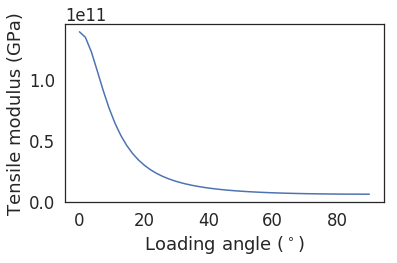

In [273]:
x = np.linspace(0, pi/2)
sns.set(font_scale=1.5)
sns.set_style("white")

fig = plt.plot(np.degrees(x), Ex_th(x))
plt.xlabel('Loading angle ($^\circ$)')
plt.ylabel('Tensile modulus (GPa)')
plt.tight_layout()
plt.savefig('../figs/theory_modulus.pdf', format = 'pdf')

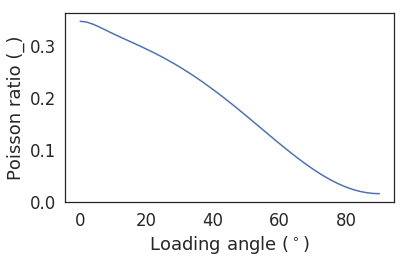

In [274]:
plt.plot(np.degrees(x), nuxy_th(x))
plt.xlabel('Loading angle ($^\circ$)')
plt.ylabel('Poisson ratio (_)')
plt.tight_layout()
plt.savefig('../figs/theory_poisson.pdf', format = 'pdf')

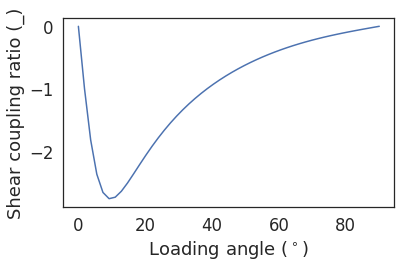

In [275]:
plt.plot(np.degrees(x), etaxy_th(x))
plt.xlabel('Loading angle ($^\circ$)')
plt.ylabel('Shear coupling ratio (_)')
plt.tight_layout()

plt.savefig('../figs/theory_coupling.pdf', format = 'pdf')

/home/m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


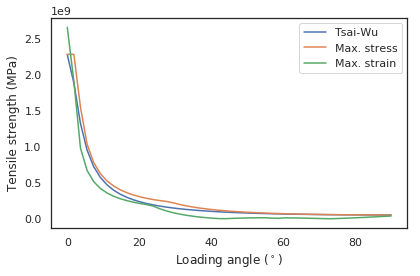

In [278]:
sns.set(font_scale=1.2)
sns.set(style='white')
plt.plot(np.degrees(x), sigma_star_2(x), label = 'Tsai-Wu')
plt.plot(np.degrees(x), sigma_star_ms(x), label = 'Max. stress')
sigma_star_mstrain_plot = []
for theta in x:
    sigma_star_mstrain_plot.append(sigma_star_mstrain(theta))
plt.plot(np.degrees(x), sigma_star_mstrain_plot, label = 'Max. strain')
plt.xlabel('Loading angle ($^\circ$)')
plt.ylabel('Tensile strength (MPa)')
plt.legend()
plt.tight_layout()
plt.savefig('../figs/theory_strength.pdf', format = 'pdf')

In [ ]:
plt.plot(np.degrees(x), sigma_star_ms(x))
plt.xlabel('Loading angle ($^\circ$)')
plt.ylabel('Tensile strength (MPa)')
plt.tight_layout()
plt.savefig('../figs/theory_strength_ms.pdf', format = 'pdf')

And calculate theoretical values:

In [ ]:
Ex_th_vals = Ex_th(angles)
nuxy_th_vals = nuxy_th(angles)
etaxy_th_vals = etaxy_th(angles)
print(Ex_th_vals, nuxy_th_vals, etaxy_th_vals)

To compare with:

In [ ]:
vals_15.describe()

In [ ]:
vals_30.describe()

In [ ]:
vals_45.describe()

## Summaries

In [ ]:
def make_summary(*args):
    args = list(args)
    summary = args.pop(0)
    
    for arg in args:
        summary = summary.join(arg)
   
    mean = summary.mean()
    std_dev = summary.std()
    DOV = summary.std() / summary.mean() * 100

    summary.loc['Mean'] = mean
    summary.loc['Standard deviation'] = std_dev
    summary.loc['DOV'] = DOV

    latex_tab = summary.to_latex(float_format='%.2f', escape = False)
    
    print(latex_tab)
    return summary, latex_tab

In [ ]:
UD15_summary, _ = make_summary(vals_15)

In [ ]:
UD30_summary, _ = make_summary(vals_30)

In [ ]:
UD45_summary, _ = make_summary(vals_45)

## Comparison with strain gauge data

In [ ]:
data.head()

In [ ]:
strain_trans_gauge = data['Strain gauge +45 (_)'] + data['Strain gauge -45 (_)'] - data['Strain gauge 0 (_)']

In [ ]:
strain_shear_gauge = data['Strain gauge +45 (_)'] - data['Strain gauge -45 (_)']

In [ ]:
data = data.assign(gauge_transverse = strain_trans_gauge, gauge_shear = strain_shear_gauge)
data = data.rename(columns = {'gauge_transverse':'Transverse strain gauge (_)', 'gauge_shear':'Shear strain gauge (_)'})

In [ ]:
data['Strain gauge 0 (_)'] = data['Strain gauge 0 (_)'].abs()

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("white")
fig, ax = plt.subplots(1)
sns.relplot(x = 'Strain gauge 0 (_)', y = 'Shear strain gauge (_)', data = data.loc['UD30', 'Sample 0'], kind = 'line', ax=ax)
sns.relplot(x = 'Longitudinal strain (_)', y = 'Shear strain (_)', data = data.loc['UD30', 'Sample 0'], kind = 'line', ax=ax)
plt
fig.savefig('../figs/strain_gauge_data.pdf', format = 'pdf')

In [ ]:
tempdata = data.loc['UD30', 'Sample 0']
plt.plot(tempdata['Longitudinal strain (_)'], tempdata['Shear strain (_)'], label = 'DIC')
plt.plot(tempdata['Strain gauge 0 (_)'], tempdata['Shear strain gauge (_)'], label = 'Strain gauge')
plt.xlabel('Longitudinal strain (_)')
plt.ylabel('Shear strain (_)')
plt.legend()
plt.tight_layout()
plt.savefig('../figs/strain_gauge_data.pdf', format = 'pdf')

In [ ]:
sns.relplot(x = 'Strain gauge 0 (_)' , y = ['Shear strain gauge (_)', 'Shear strain (_)'], data = data.loc['UD15', 'Sample 3'], kind = 'line')
sns.relplot(x = 'Longitudinal strain (_)', y = 'Shear strain (_)', data = data.loc['UD15', 'Sample 3'], kind = 'line')

In [ ]:
sns.relplot(x = 'Strain gauge 0 (_)', y = 'Shear strain gauge (_)', data = data.loc['UD45', 'Sample 2'], kind = 'line')

In [ ]:
def get_vals_gauge(data, strain_low, strain_high):
    E1_gauge = calc_moduli(data, 'Strain gauge 0 (_)', strain_low, strain_high, 5, '$E_{x}$')
    nuxy_gauge = calc_poisson(data, 'Strain gauge 0 (_)', 'Transverse strain gauge (_)',  strain_low, strain_high, 5, '$\nu_{xy}$')
    etaxy_gauge =  calc_poisson(data, 'Strain gauge 0 (_)', 'Shear strain gauge (_)',  strain_low, strain_high, 5, '$\eta_{xy}$')
    etaxy_gauge = etaxy_gauge.abs()
    return pd.concat([E1_gauge, nuxy_gauge, etaxy_gauge], axis = 1, sort=False) 

In [ ]:
vals_15_gauge = get_vals_gauge(data.loc['UD15'], 0.0005, 0.0015).loc['Sample 3']

In [ ]:
vals_30_gauge = get_vals_gauge(data.loc['UD30'], 0.0005, 0.0015).loc['Sample 0']
vals_30_gauge

In [ ]:
vals_45_gauge = get_vals_gauge(data.loc['UD45'], 0.0005, 0.0015).loc['Sample 2']

In [ ]:
gauge_data = pd.concat([vals_15_gauge, vals_30_gauge, vals_45_gauge], axis = 1)
gauge_data.columns = ['$15^{\circ}$', '$30^{\circ}$', '$45^{\circ}$']
gauge_data
print(gauge_data.to_latex(float_format='%.2f', escape = False))


Error analysis

In [295]:
error_mult = lambda val, errors: val * np.sqrt(np.sum(np.square(errors)))

In [296]:
error_mult(37.7, [0.03, 0.01, 0.005, 0.02])

1.4231437910485365

In [297]:
error_mult(167.34, [0.03, 0.01, 0.005])

5.3574940494600645

In [298]:
error_mult(0.44, [0.02, 0.02])

0.012445079348883236

In [299]:
error_mult(2.05, [0.02, 0.02, 0.02])

0.07101408311032396

In [300]:
error_mult(15.12, [0.03, 0.01, 0.005, 0.02])

0.5707674833064686

In [301]:
error_mult(10.54, [0.03, 0.01, 0.005, 0.02])

0.39787627473876847

In [302]:
error_mult(67.45, [0.03, 0.01, 0.005])

2.159453649074228

In [303]:
error_mult(60.76, [0.03, 0.01, 0.005])

1.9452691433320994

In [304]:
error_mult(0.41, [0.02, 0.02])

0.01159655121145938

In [305]:
error_mult(0.32, [0.02, 0.02])

0.009050966799187809

In [306]:
error_mult(1.30, [0.02, 0.02, 0.02])

0.04503332099679081

In [307]:
error_mult(0.50, [0.02, 0.02, 0.02])

0.017320508075688773

In [308]:
error_mult(0.60, [0.02, 0.02, 0.02])

0.020784609690826527